# idea

Create an inner loop that adds the time dimension in

This is an attempt to not require me to explicitly create the waveform (t,q,chi,...) hypersurface

In [ ]:
# https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch

In [3]:
from tensorflow.keras.utils import get_custom_objects
import pugna.activations
import pugna.layers
import pugna.models
import pugna.callbacks
import wispy.mscalev2
import wispy.mscalev3
import wispy.model_utils
import wispy.callbacks
import wispy.utils
import wispy.logger
import wispy.resnet
import wispy
import subprocess
import datetime
import argparse
import sys
import os
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorboard as tb
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
# https://stackoverflow.com/a/59789336/12840171
# this is the way to add custome activations - do not do
# get_custom_objects().update({'srelu': tf.keras.layers.Activation(pugna.activations.sReLU)})
# get_custom_objects().update({'s2relu': tf.keras.layers.Activation(pugna.activations.s2relu)})
# instead to
# otherwise problems with saving and loading
get_custom_objects().update({'srelu': pugna.activations.sReLU})
get_custom_objects().update({'s2relu': pugna.activations.s2relu})

In [6]:

def compute_fft(x, y):
    """
    function to compute the fourier transform and sample frequencies.
    only keeping the positive side of the fft and normalising.
    """
    N = len(x)
    dt = x[1] - x[0]
    
    yf = 2.0/N * np.fft.fft(y)[:N//2]
    xf = np.fft.fftfreq(N, dt)[:N//2]

    return xf, yf

def plot_fft(x, y, model=None, xlim=None, logx=False, logy=False):
    xf, yf = compute_fft(x[:,0], y[:,0])
    
    plt.figure(figsize=(14, 6))
    plt.plot(xf, np.abs(yf), label='total')
    
    if model is not None:
        plt.plot(xf, np.abs(compute_fft(x[:,0], model.predict(x)[:,0]))[1], ls='--', label='model', c='k')
        
    plt.axvline(1, c='k', ls='--')
    plt.axvline(4, c='k', ls='--')
    plt.xlabel("f")
    plt.ylabel("|fft(y)|")
    if xlim:
        plt.xlim(xlim)
    else:
        plt.xlim(0,10)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
    if logx:
        plt.xscale('log')
    if logy:
        plt.yscale('log')

# models

In [8]:
def get_uncompiled_model(model_name, model_params_dict):
    assert model_name in ['resnet', 'mscalev2', 'mscalev1', 'mscalev3']

    if model_name == 'resnet':
        model = wispy.resnet.ResNet(**model_params_dict)
    elif model_name == 'mscalev2':
        model = wispy.mscalev2.build_model(**model_params_dict)
    elif model_name == 'mscalev1':
        model = pugna.models.mscalednn.build_model_2(**model_params_dict)
    elif model_name == 'mscalev3':
        model = wispy.mscalev3.build_model(**model_params_dict)

    return model


def get_compiled_model(model_name, model_params_dict, extra_params_dict):
    model = get_uncompiled_model(
        model_name=model_name, model_params_dict=model_params_dict)

    optimizer = tf.keras.optimizers.Adam(
        extra_params_dict['lr'], amsgrad=extra_params_dict['amsgrad'])

    model.compile(loss=extra_params_dict['loss'],
                  optimizer=optimizer, metrics=extra_params_dict['metrics'])

    return model

# load data

In [199]:
X_train_raw = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/X_train.npy')[:1119]
y_train_raw = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/y_train.npy')[:1119]

# X_train_raw = X_train_raw[:,0].reshape(-1, 1)
X_train_raw = X_train_raw[:,:2].reshape(-1, 2)

# X_val = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/X_val.npy')[:1119]
# y_val = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/y_val.npy')[:1119]

print(f"X_train_raw.shape: {X_train_raw.shape}")
print(f"y_train_raw.shape: {y_train_raw.shape}")
# print(f"X_val.shape: {X_val.shape}")
# print(f"y_val.shape: {y_val.shape}")

# lets just use 1D input - i.e., time-series
X_train = X_train_raw.copy()
y_train = y_train_raw.copy()

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.33, random_state=42)

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_val.shape: {X_val.shape}")
print(f"y_val.shape: {y_val.shape}")

X_train_raw.shape: (1119, 2)
y_train_raw.shape: (1119, 1)
X_train.shape: (749, 2)
y_train.shape: (749, 1)
X_val.shape: (370, 2)
y_val.shape: (370, 1)


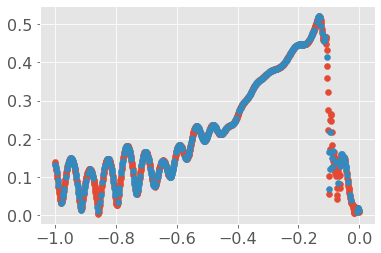

In [201]:
plt.figure()
plt.scatter(X_train[:,0], y_train)
plt.scatter(X_val[:,0], y_val)

# create tf datasets

In [202]:
buffer_size = 749
# batch_size = 749
batch_size = 200

In [203]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=buffer_size).batch(batch_size)
# train_dataset = train_dataset.batch(batch_size)

In [204]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.shuffle(buffer_size=buffer_size).batch(batch_size)
# val_dataset = val_dataset.batch(batch_size)

# base line

In [205]:
model_params_dict = dict(
    input_shape=2,
    output_shape=1,
    units=[128,128,128],
    activation='s2relu',
    n_blocks=[2,2,2],
    scales=[1,10,100],
    layers_per_block=3,
    scale_dimension=0,
    dtype=None
)

In [206]:
extra_params_dict=dict(lr=1e-3, amsgrad=False, loss='mse', metrics=None)

In [207]:
base_model = get_compiled_model(model_name='mscalev3', model_params_dict=model_params_dict, extra_params_dict=extra_params_dict)

In [208]:
%%time
base_history = base_model.fit(train_dataset, epochs=1001, validation_data=val_dataset, verbose=0)

CPU times: user 2min 44s, sys: 1min 22s, total: 4min 6s
Wall time: 1min 17s


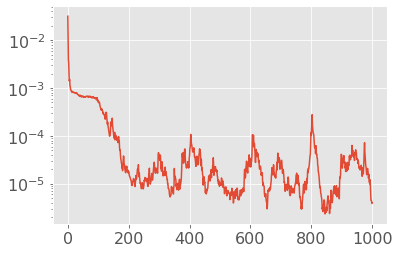

In [209]:
plt.figure()
plt.plot(base_history.history['loss'])
plt.yscale('log')

In [210]:
base_yhat = base_model.predict(X_train)

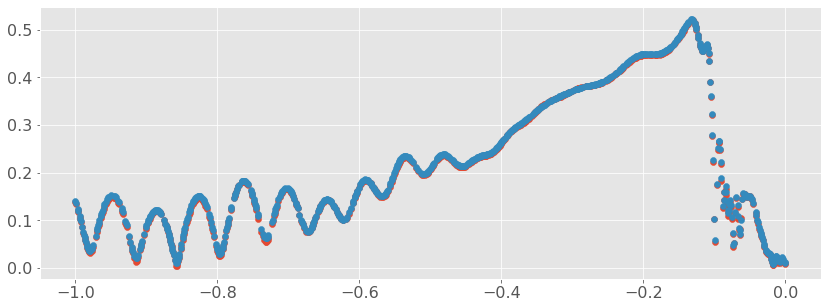

In [211]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], y_train)
plt.scatter(X_train[:,0], base_yhat)
# plt.xlim(-0.2, 0)

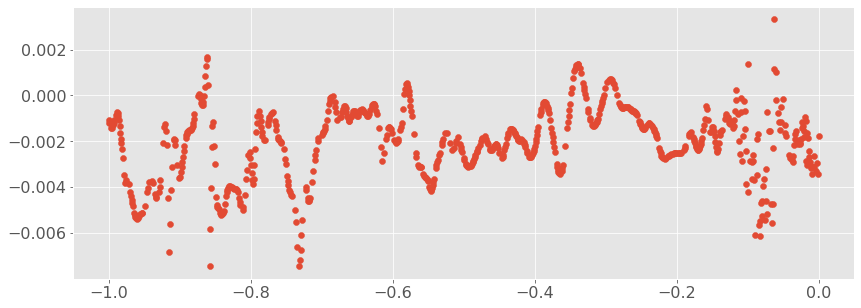

In [212]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], y_train-base_yhat)

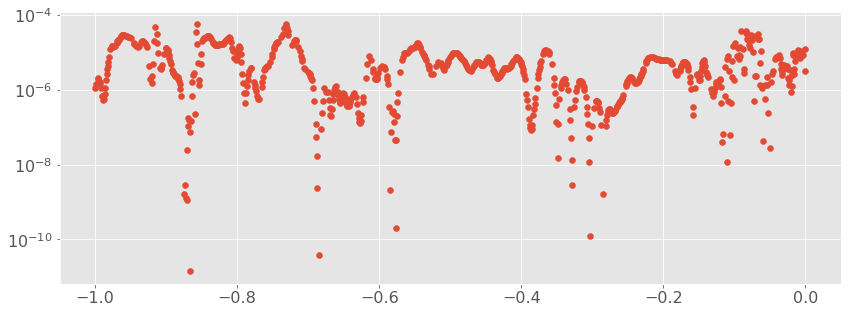

In [213]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], tf.keras.losses.mean_squared_error(y_train,base_yhat))
plt.yscale('log')

# dev

In [214]:
# trying to fit a single waveform with a custom training loop

In [215]:
# lets create an mscale model

In [216]:
model = get_uncompiled_model(
    model_name='mscalev3',
    model_params_dict=model_params_dict)

In [217]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [218]:
loss_fn = tf.keras.losses.mean_squared_error

In [219]:
# Prepare the metrics.
train_loss_metric = tf.keras.metrics.MeanSquaredError()
val_loss_metric = tf.keras.metrics.MeanSquaredError()

In [220]:
import time

In [221]:
# training and eval loop

In [222]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        yhat = model(x_batch_train, training=True)
        loss_value = loss_fn(y_batch_train, yhat)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # update training metric
    train_loss_metric.update_state(y_batch_train, yhat)
    return loss_value

In [223]:
total_start_time = time.time()
# losses_per_iteration = tf.zeros(shape=(32, ), dtype=tf.float32)
losses_per_iteration = []
avg_losses_per_iteration = []
avg_losses_per_epoch = []

epochs = 1001
for epoch in range(epochs):
#     print(f"\nStart of epoch {epoch}")
    start_time = time.time()
    
    # iterate over the batches of the dataset
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss_value = train_step(x_batch_train, y_batch_train)
#         losses_per_iteration.append(loss_value)
#         losses_per_iteration = tf.concat([losses_per_iteration, loss_value], axis=-1)

        losses_per_iteration.append(loss_value)
        avg_losses_per_iteration.append(tf.reduce_mean(loss_value))
#         if step % 200 == 0:
#             print(f"Training loss (mean over one batch) at step {epoch}: {tf.reduce_mean(loss_value)}")
#             print(f"Seen so far: {(step+1)*batch_size} samples")
            
#     print(f"Training loss over epoch: {float(train_loss_metric.result())}")
    if epoch % 500 == 0: 
        print(f"epoch:{epoch}, loss:{float(train_loss_metric.result())}")

    avg_losses_per_epoch.append(train_loss_metric.result())
    # reset training metric at end of each epoch
    train_loss_metric.reset_states()
    
#     print(f"Time take: {time.time() - start_time}")
print(f"Total Time taken: {time.time() - total_start_time}")

epoch:0, loss:0.0809098482131958
epoch:500, loss:3.336434417633427e-07
epoch:1000, loss:2.2611766326008365e-06
Total Time taken: 42.365185022354126


In [224]:
# losses_per_iteration

In [225]:
len(avg_losses_per_epoch)

1001

In [226]:
plot_losses_per_iteration = [val.numpy() for val in losses_per_iteration]

In [227]:
plot_losses_per_iteration=np.concatenate((plot_losses_per_iteration), axis=-1)

In [228]:
plot_avg_losses_per_iteration = np.array([val.numpy() for val in avg_losses_per_iteration])

In [229]:
plot_avg_losses_per_epoch = np.array([val.numpy() for val in avg_losses_per_epoch])

In [230]:
plot_losses_per_iteration = plot_losses_per_iteration.reshape(-1, 1)

In [231]:
plot_avg_losses_per_epoch.shape

(1001,)

In [232]:
plot_losses_per_iteration.shape

(749749, 1)

In [233]:
plot_avg_losses_per_iteration.shape

(4004,)

In [234]:
model

In [235]:
yhat = model.predict(X_train)

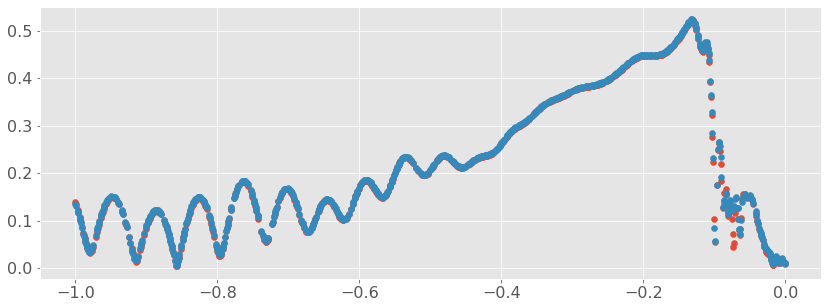

In [236]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], y_train)
plt.scatter(X_train[:,0], yhat)
# plt.xlim(-0.2, 0)

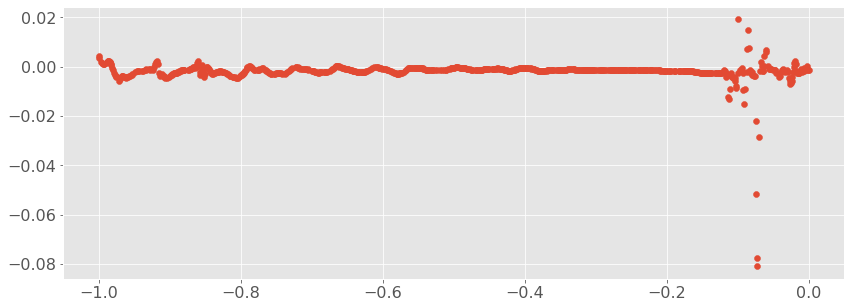

In [237]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], y_train-yhat)

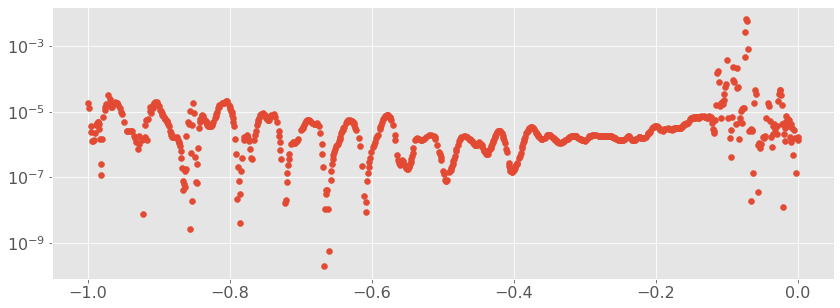

In [238]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], loss_fn(y_train,yhat))
plt.yscale('log')

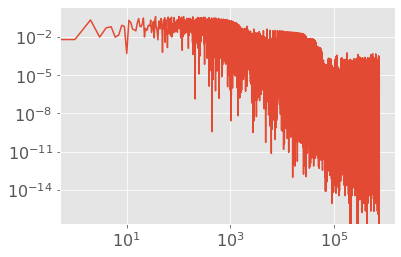

In [239]:
plt.figure()
plt.plot(range(plot_losses_per_iteration.shape[0]), plot_losses_per_iteration)
plt.yscale('log')
plt.xscale('log')
# plt.xlim(1e6-230000, 1e6)
# for i in range(400000, 400300):
#     plt.axvline(i+23, c='k')

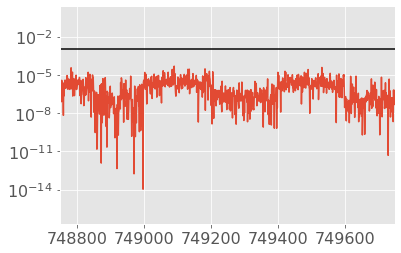

In [240]:
plt.figure()
plt.plot(range(plot_losses_per_iteration.shape[0]), plot_losses_per_iteration)
plt.yscale('log')
# plt.xscale('log')
# plt.xlim(1e6-230000, 1e6)
# for i in range(400000, 400300):
#     plt.axvline(i+23, c='k')
plt.xlim(plot_losses_per_iteration.shape[0]-1000, plot_losses_per_iteration.shape[0])
plt.axhline(1e-3, c='k')

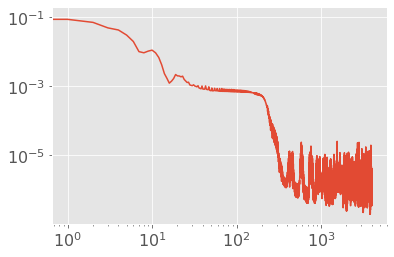

In [241]:
plt.figure()
plt.plot(range(plot_avg_losses_per_iteration.shape[0]), plot_avg_losses_per_iteration)
plt.yscale('log')
plt.xscale('log')

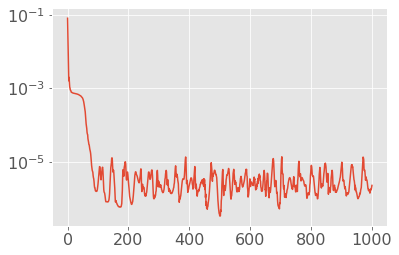

In [242]:
plt.figure()
plt.plot(range(plot_avg_losses_per_epoch.shape[0]), plot_avg_losses_per_epoch)
plt.yscale('log')
# plt.xscale('log')

# compare 

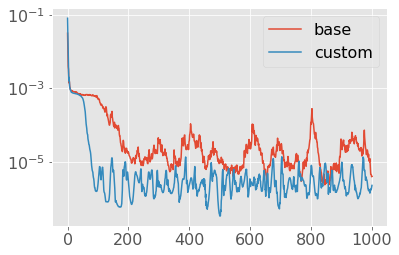

In [244]:
plt.figure()
plt.plot(base_history.history['loss'], label='base')
plt.plot(plot_avg_losses_per_epoch, label='custom')
plt.yscale('log')
# plt.xscale('log')
plt.legend()

# an aisde on fit residuals for fun

In [245]:
res_y_train = y_train-base_yhat
res_y_train *= 500

In [246]:
res_y_val = y_val-base_model.predict(X_val)
res_y_val *= 500

In [247]:
extra_params_dict_2 = extra_params_dict.copy()

In [248]:
extra_params_dict_2.update({'lr':1e-3})

In [249]:
res_base_model = get_compiled_model(model_name='mscalev3', model_params_dict=model_params_dict, extra_params_dict=extra_params_dict_2)

In [250]:
%%time
res_base_history = res_base_model.fit(X_train, res_y_train, epochs=1001, validation_data=(X_val, res_y_val), verbose=0)

CPU times: user 3min 44s, sys: 40.4 s, total: 4min 25s
Wall time: 1min 32s


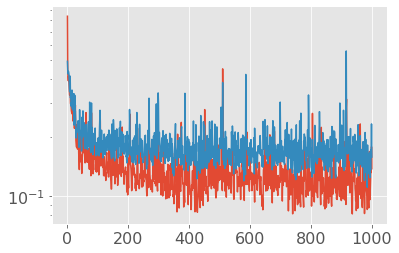

In [251]:
plt.figure()
plt.plot(res_base_history.history['loss'])
plt.plot(res_base_history.history['val_loss'])
plt.yscale('log')

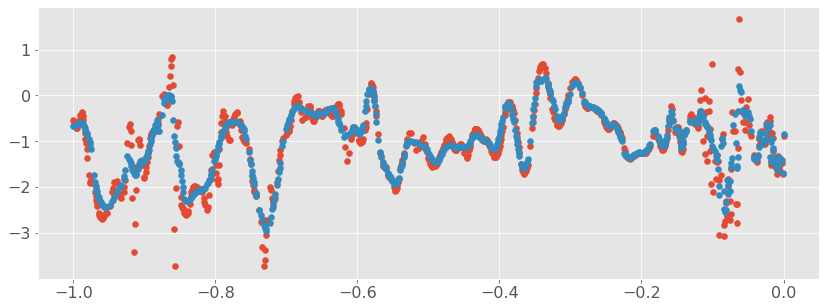

In [253]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], res_y_train)
plt.scatter(X_train[:,0], res_base_model.predict(X_train))
# plt.xlim(-0.2, 0)

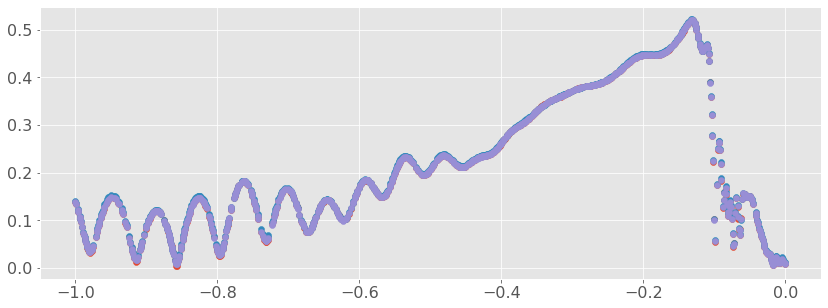

In [261]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], y_train)
plt.scatter(X_train[:,0], base_yhat)
plt.scatter(X_train[:,0], base_yhat+res_base_model.predict(X_train)/500)
# plt.xlim(-0.2, 0)

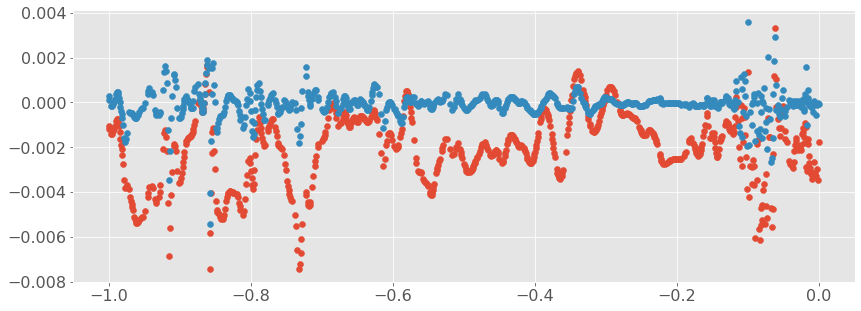

In [263]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], y_train-base_yhat)
plt.scatter(X_train[:,0], y_train-(base_yhat+res_base_model.predict(X_train)/500))

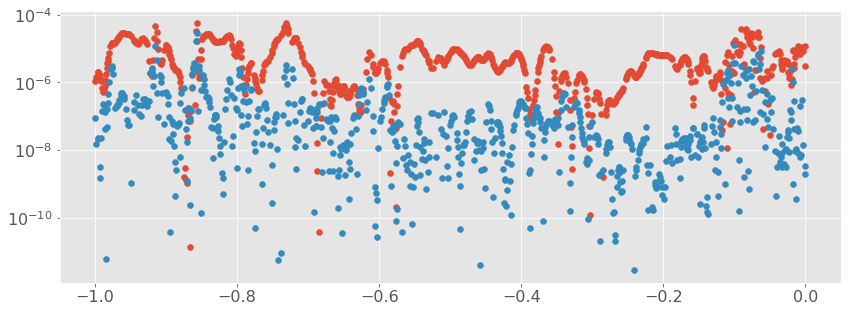

In [256]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], tf.keras.losses.mean_squared_error(y_train,base_yhat))
plt.scatter(X_train[:,0], tf.keras.losses.mean_squared_error(y_train,(base_yhat+res_base_model.predict(X_train)/500)))
plt.yscale('log')

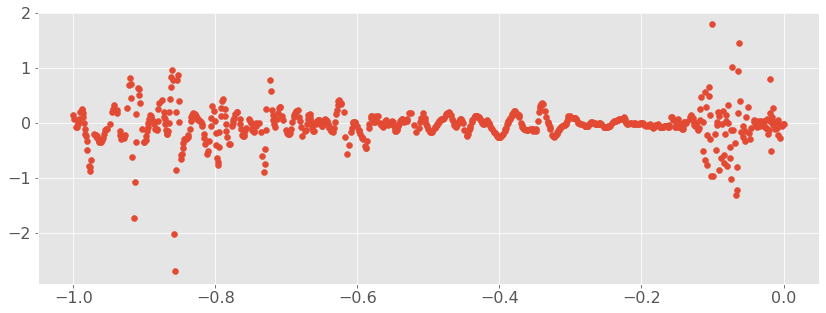

In [257]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], res_y_train-res_base_model.predict(X_train))
# plt.xlim(-0.2, 0)

# trying to add time separately

# load data - two waveforms

In [355]:
index_one_wf = 1119

X_train_raw = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/X_train.npy')[:index_one_wf*2]
y_train_raw = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/y_train.npy')[:index_one_wf*2]

print(X_train_raw.shape)

# X_train_raw = X_train_raw[:,0].reshape(-1, 1)
X_train_raw = X_train_raw[:,:3].reshape(-1, 3)

# X_val = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/X_val.npy')[:1119]
# y_val = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/y_val.npy')[:1119]

print(f"X_train_raw.shape: {X_train_raw.shape}")
print(f"y_train_raw.shape: {y_train_raw.shape}")
# print(f"X_val.shape: {X_val.shape}")
# print(f"y_val.shape: {y_val.shape}")

# lets just use 1D input - i.e., time-series
X_train = X_train_raw.copy()
y_train = y_train_raw.copy()

# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train, test_size=0.33, random_state=42)

# print(f"X_train.shape: {X_train.shape}")
# print(f"y_train.shape: {y_train.shape}")
# print(f"X_val.shape: {X_val.shape}")
# print(f"y_val.shape: {y_val.shape}")

(2238, 10)
X_train_raw.shape: (2238, 3)
y_train_raw.shape: (2238, 1)


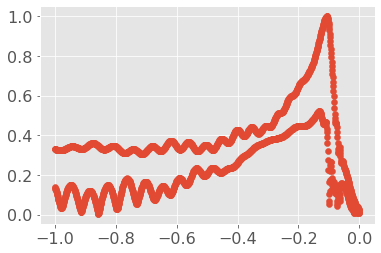

In [356]:
plt.figure()
plt.scatter(X_train[:,0], y_train)
# plt.scatter(X_val[:,0], y_val)

In [357]:
X_train.shape

(2238, 3)

In [358]:
X_train

array([[-1.00000000e+00,  6.72379423e+00,  9.90000000e-01],
       [-9.99105546e-01,  6.72379423e+00,  9.90000000e-01],
       [-9.98211091e-01,  6.72379423e+00,  9.90000000e-01],
       ...,
       [-1.78890877e-03,  3.06813690e+00,  9.90000000e-01],
       [-8.94454383e-04,  3.06813690e+00,  9.90000000e-01],
       [ 0.00000000e+00,  3.06813690e+00,  9.90000000e-01]])

In [359]:
# lets split this into time and physical parameters qs

In [360]:
times = X_train[:index_one_wf,0].reshape(-1, 1)

In [361]:
times.shape

(1119, 1)

In [362]:
# first physical feature - mass-ratio
q0s = X_train[:,1].reshape(-1, 1)

In [363]:
# second physical feature - spin
q1s = X_train[:,2].reshape(-1, 1)

In [364]:
q0s.shape

(2238, 1)

In [365]:
q1s.shape

(2238, 1)

In [442]:
unique_q0s = np.unique(q0s)

In [443]:
unique_q0s

array([3.0681369 , 6.72379423])

In [445]:
unique_q1s = np.unique(q1s)

In [446]:
unique_q1s

array([0.99])

In [460]:
unique_qs = np.array([
    [6.72379423, 0.99],[3.0681369, 0.99]
])

In [461]:
unique_qs.shape

(2, 2)

In [462]:
unique_qs[0]

array([6.72379423, 0.99      ])

In [463]:
qs=np.column_stack((q0s, q1s))

In [464]:
qs.shape

(2238, 2)

In [465]:
qs

array([[6.72379423, 0.99      ],
       [6.72379423, 0.99      ],
       [6.72379423, 0.99      ],
       ...,
       [3.0681369 , 0.99      ],
       [3.0681369 , 0.99      ],
       [3.0681369 , 0.99      ]])

In [466]:
# note that in this case because we only have one waveform then the qs array is just the same number repeated
# and that we can just take the first column to get the times

In [467]:
y_train.shape

(2238, 1)

In [468]:
TARGET_MATRIX = X_train.copy()

In [469]:
# this is the training data in its most explicit form - this is what I want to recreate implicitly
# using a custom training loop
TARGET_MATRIX

array([[-1.00000000e+00,  6.72379423e+00,  9.90000000e-01],
       [-9.99105546e-01,  6.72379423e+00,  9.90000000e-01],
       [-9.98211091e-01,  6.72379423e+00,  9.90000000e-01],
       ...,
       [-1.78890877e-03,  3.06813690e+00,  9.90000000e-01],
       [-8.94454383e-04,  3.06813690e+00,  9.90000000e-01],
       [ 0.00000000e+00,  3.06813690e+00,  9.90000000e-01]])

In [470]:
ones = np.ones([times.shape[0], 2])

In [471]:
ones.shape

(1119, 2)

In [472]:
# three_d = np.column_stack((times, (qs[0].reshape(-1, 2)) * ones))
three_d = np.column_stack((times, (unique_qs[0].reshape(-1, 2)) * ones))

In [473]:
three_d.shape

(1119, 3)

In [474]:
three_d

array([[-1.00000000e+00,  6.72379423e+00,  9.90000000e-01],
       [-9.99105546e-01,  6.72379423e+00,  9.90000000e-01],
       [-9.98211091e-01,  6.72379423e+00,  9.90000000e-01],
       ...,
       [-1.78890877e-03,  6.72379423e+00,  9.90000000e-01],
       [-8.94454383e-04,  6.72379423e+00,  9.90000000e-01],
       [ 0.00000000e+00,  6.72379423e+00,  9.90000000e-01]])

In [475]:
TARGET_MATRIX[:index_one_wf].shape

(1119, 3)

In [476]:
TARGET_MATRIX[:index_one_wf]

array([[-1.00000000e+00,  6.72379423e+00,  9.90000000e-01],
       [-9.99105546e-01,  6.72379423e+00,  9.90000000e-01],
       [-9.98211091e-01,  6.72379423e+00,  9.90000000e-01],
       ...,
       [-1.78890877e-03,  6.72379423e+00,  9.90000000e-01],
       [-8.94454383e-04,  6.72379423e+00,  9.90000000e-01],
       [ 0.00000000e+00,  6.72379423e+00,  9.90000000e-01]])

In [477]:
TARGET_MATRIX.shape

(2238, 3)

In [478]:
np.testing.assert_array_almost_equal(TARGET_MATRIX[:index_one_wf], three_d)

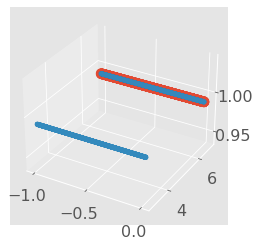

In [479]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(three_d[:,0], three_d[:,1], three_d[:,2], s=100)
ax.scatter(TARGET_MATRIX[:,0], TARGET_MATRIX[:,1], TARGET_MATRIX[:,2])

In [391]:
#pseudo training loop code
# we use this to broadcast the physics params so that we can concat the times
# ones = np.ones([times.shape[0], 2])
# for epoch in range(epochs):
#     # iterate over the batches of the dataset
#     for step, q in enumerate(q0s):
#         # three_d is the input data
#         three_d = np.column_stack((times, (q.reshape(-1, 2)) * ones))
#         loss_value = train_step(three_d[step], y_train[step])
#     print(f"epoch:{epoch}, loss:{float(train_loss_metric.result())}")
#     train_loss_metric.reset_states()

In [579]:
custom_model_params_dict = dict(
    input_shape=3,
    output_shape=1,
    units=[128,128,128],
    activation='s2relu',
    n_blocks=[2,2,2],
    scales=[1,10,100],
    layers_per_block=3,
    scale_dimension=0,
    dtype=None
)

In [580]:
custom_model = get_uncompiled_model(
    model_name='mscalev3',
    model_params_dict=custom_model_params_dict)

In [581]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [582]:
loss_fn = tf.keras.losses.mean_squared_error

In [583]:
# Prepare the metrics.
train_loss_metric = tf.keras.metrics.MeanSquaredError()
val_loss_metric = tf.keras.metrics.MeanSquaredError()

In [584]:
import time

In [585]:
# training and eval loop

In [586]:
@tf.function
def custom_train_step(x, y):
    with tf.GradientTape() as tape:
        yhat = custom_model(x, training=True)
        loss_value = loss_fn(y, yhat)
    grads = tape.gradient(loss_value, custom_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, custom_model.trainable_weights))

    # update training metric
    train_loss_metric.update_state(y, yhat)
    return loss_value

In [587]:
qs.shape

(2238, 2)

In [588]:
y_train.shape


(2238, 1)

In [589]:
custom_y_train = y_train.reshape(2, 1119, 1)

In [590]:
custom_y_train.shape

(2, 1119, 1)

In [591]:
qs.shape

(2238, 2)

In [592]:
y_train[:1119].shape

(1119, 1)

In [593]:
y_train[1119:].shape

(1119, 1)

In [594]:
three_d.shape

(1119, 3)

In [595]:
unique_qs

array([[6.72379423, 0.99      ],
       [3.0681369 , 0.99      ]])

In [596]:
total_start_time = time.time()


# we use this to broadcast the physics params so that we can concat the times
ones = np.ones([times.shape[0], 2])


# losses_per_iteration = tf.zeros(shape=(32, ), dtype=tf.float32)
losses_per_iteration = []
avg_losses_per_iteration = []
avg_losses_per_epoch = []

epochs = 1001
for epoch in range(epochs):
#     print(f"\nStart of epoch {epoch}")
    start_time = time.time()
    
    
#     for step, (q, yt) in enumerate(zip(qs, custom_y_train)):
    for q_step, q in enumerate(unique_qs):
#         print(f"q_step: {q_step}")
        # three_d is the input data
        three_d = np.column_stack((times, (q.reshape(-1, 2)) * ones))
        
#         for step, (xt, yt) in enumerate(zip(three_d, y_train)):
#             print(xt, yt)
#             loss_value = custom_train_step(xt.reshape(1, -1), yt.reshape(1,1))
#             loss_value = custom_train_step(xt, yt)
#             losses_per_iteration.append(loss_value)
#             avg_losses_per_iteration.append(tf.reduce_mean(loss_value))
#             if step % 200 == 0:
#                 print(f"Training loss (mean over one batch) at step {step}: {tf.reduce_mean(loss_value)}")
        loss_value = custom_train_step(three_d, custom_y_train[q_step])
        losses_per_iteration.append(loss_value)
        avg_losses_per_iteration.append(tf.reduce_mean(loss_value))
    
    
#     print(f"Training loss over epoch: {float(train_loss_metric.result())}")
#     if epoch % 500 == 0: 
#         print(f"epoch:{epoch}, loss:{float(train_loss_metric.result())}")
    print(f"epoch:{epoch}, loss:{float(train_loss_metric.result())}")

    avg_losses_per_epoch.append(train_loss_metric.result())
    # reset training metric at end of each epoch
    train_loss_metric.reset_states()
    
#     print(f"Time take: {time.time() - start_time}")
print(f"Total Time taken: {time.time() - total_start_time}")

epoch:0, loss:0.1072329580783844
epoch:1, loss:0.06764958798885345
epoch:2, loss:0.03706635907292366
epoch:3, loss:0.015149949118494987
epoch:4, loss:0.009335927665233612
epoch:5, loss:0.013835438527166843
epoch:6, loss:0.009406807832419872
epoch:7, loss:0.004136997275054455
epoch:8, loss:0.0020499303936958313
epoch:9, loss:0.0020319123286753893
epoch:10, loss:0.002282944042235613
epoch:11, loss:0.0019628487061709166
epoch:12, loss:0.0014872910687699914
epoch:13, loss:0.0012199647026136518
epoch:14, loss:0.000976647948846221
epoch:15, loss:0.0007791000534780324
epoch:16, loss:0.0007294319220818579
epoch:17, loss:0.0007781528402119875
epoch:18, loss:0.0007984480471350253
epoch:19, loss:0.00074950692942366
epoch:20, loss:0.0006665726541541517
epoch:21, loss:0.0005962388240732253
epoch:22, loss:0.0005572648951783776
epoch:23, loss:0.0005426862626336515
epoch:24, loss:0.0005383152165450156
epoch:25, loss:0.0005346887046471238
epoch:26, loss:0.0005277956952340901
epoch:27, loss:0.0005162861

In [597]:
# losses_per_iteration

In [598]:
len(avg_losses_per_epoch)

1001

In [599]:
plot_losses_per_iteration = [val.numpy() for val in losses_per_iteration]

In [600]:
plot_losses_per_iteration=np.concatenate((plot_losses_per_iteration), axis=-1)

In [601]:
plot_avg_losses_per_iteration = np.array([val.numpy() for val in avg_losses_per_iteration])

In [602]:
plot_avg_losses_per_epoch = np.array([val.numpy() for val in avg_losses_per_epoch])

In [603]:
plot_losses_per_iteration = plot_losses_per_iteration.reshape(-1, 1)

In [604]:
plot_avg_losses_per_epoch.shape

(1001,)

In [605]:
plot_losses_per_iteration.shape

(2240238, 1)

In [606]:
plot_avg_losses_per_iteration.shape

(2002,)

In [607]:
model

In [622]:
yhat = custom_model.predict(TARGET_MATRIX)

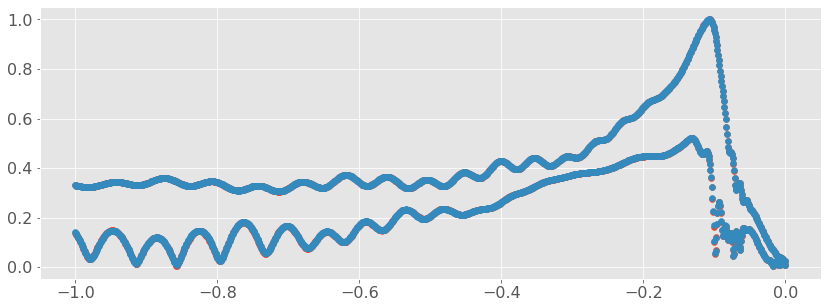

In [623]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], y_train)
plt.scatter(X_train[:,0], yhat)
# plt.xlim(-0.2, 0)

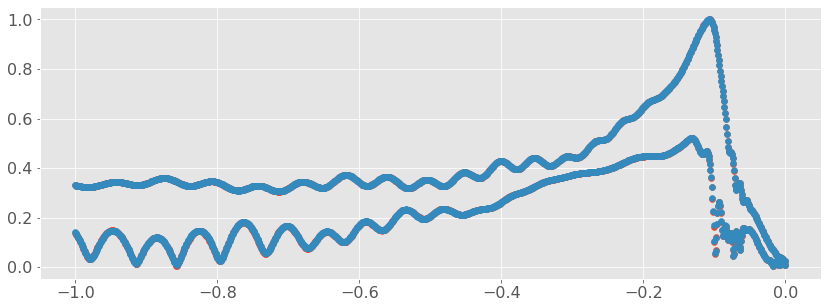

In [609]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], y_train)
plt.scatter(X_train[:,0], yhat)
# plt.xlim(-0.2, 0)

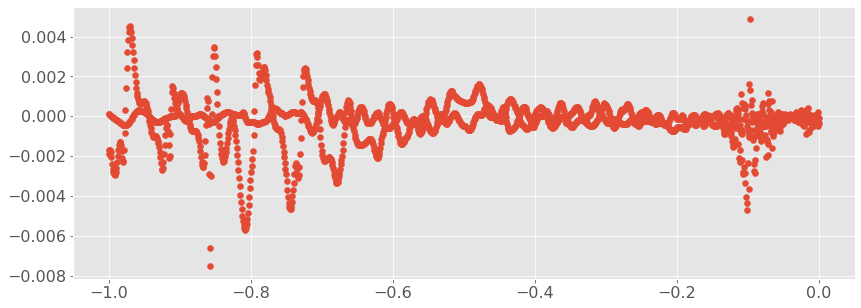

In [610]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], y_train-yhat)

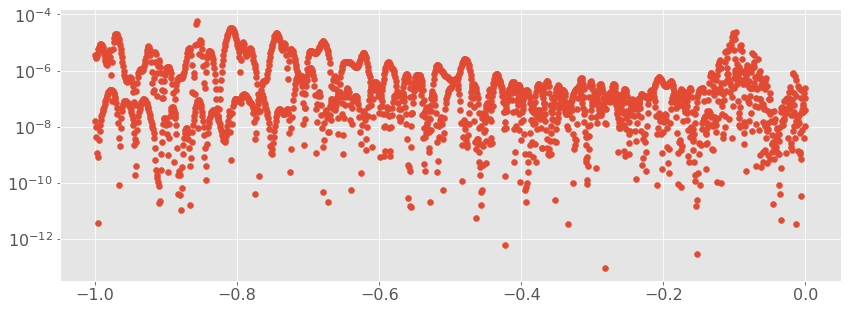

In [611]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], loss_fn(y_train,yhat))
plt.yscale('log')

In [617]:
yhat = custom_model.predict(TARGET_MATRIX[:index_one_wf])

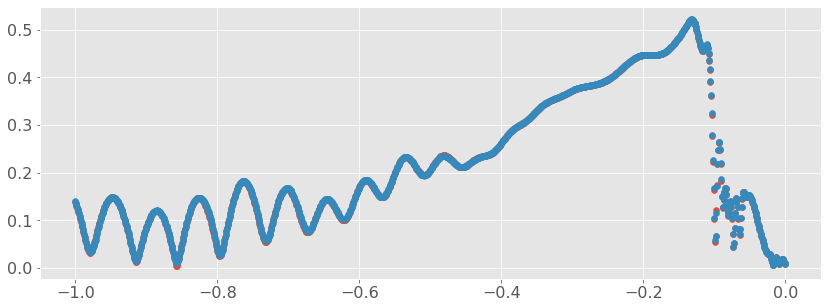

In [619]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:index_one_wf,0], y_train[:index_one_wf])
plt.scatter(X_train[:index_one_wf,0], yhat)
# plt.xlim(-0.2, 0)

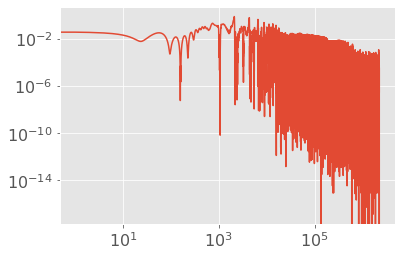

In [612]:
plt.figure()
plt.plot(range(plot_losses_per_iteration.shape[0]), plot_losses_per_iteration)
plt.yscale('log')
plt.xscale('log')
# plt.xlim(1e6-230000, 1e6)
# for i in range(400000, 400300):
#     plt.axvline(i+23, c='k')

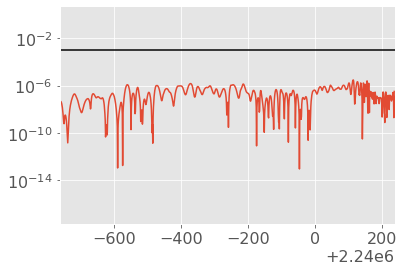

In [613]:
plt.figure()
plt.plot(range(plot_losses_per_iteration.shape[0]), plot_losses_per_iteration)
plt.yscale('log')
# plt.xscale('log')
# plt.xlim(1e6-230000, 1e6)
# for i in range(400000, 400300):
#     plt.axvline(i+23, c='k')
plt.xlim(plot_losses_per_iteration.shape[0]-1000, plot_losses_per_iteration.shape[0])
plt.axhline(1e-3, c='k')

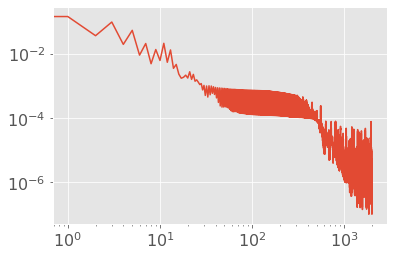

In [614]:
plt.figure()
plt.plot(range(plot_avg_losses_per_iteration.shape[0]), plot_avg_losses_per_iteration)
plt.yscale('log')
plt.xscale('log')

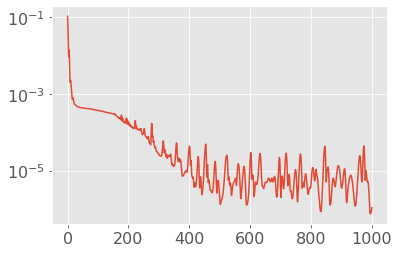

In [615]:
plt.figure()
plt.plot(range(plot_avg_losses_per_epoch.shape[0]), plot_avg_losses_per_epoch)
plt.yscale('log')
# plt.xscale('log')

# compare 

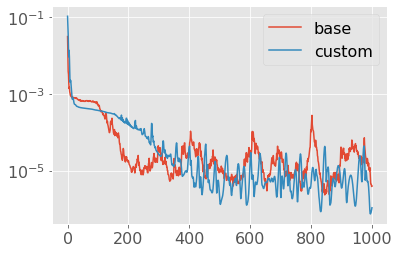

In [616]:
plt.figure()
plt.plot(base_history.history['loss'], label='base')
plt.plot(plot_avg_losses_per_epoch, label='custom')
plt.yscale('log')
# plt.xscale('log')
plt.legend()